#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Lab 6: Creating Validation Data
**Learning Objectives:**
  * Generate a train and validation data set for housing data that we will use to predict the median housing price, at the granularity of city blocks.
  * Debug issues in the creation of the train and validation splits.
  * Select the best single feature to use to train a linear model to predict the median housing price.
  * Test that the prediction loss on the validation data accurately reflect the trained model's loss on unseen test data.

### Standard Set-up

We begin with the standard set-up.  In this lab we use a data set based on 1990 census data from California. Since this data set has a header row, we don't need to provide the column names.

In [0]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn import metrics
import tensorflow as tf
from tensorflow.contrib.learn.python.learn import learn_io, estimator

# This line increases the amount of logging when there is an error. You can
# remove it if you want less logging.
tf.logging.set_verbosity(tf.logging.ERROR)

# Set the output display to have two digits for decimal places, for display
# readability only and limit it to printing 15 rows.
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

Read the data set.

In [273]:
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/ml_universities/california_housing_train.csv", sep=",")
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.00,17000.00,17000.00,17000.00,17000.00,17000.00,17000.00,17000.00,17000.00
mean,-119.56,35.63,28.59,2643.66,539.41,1429.57,501.22,3.88,207300.91
std,2.01,2.14,12.59,2179.95,421.50,1147.85,384.52,1.91,115983.76
min,-124.35,32.54,1.00,2.00,1.00,3.00,1.00,0.50,14999.00
25%,-121.79,33.93,18.00,1462.00,297.00,790.00,282.00,2.57,119400.00
50%,-118.49,34.25,29.00,2127.00,434.00,1167.00,409.00,3.54,180400.00
75%,-118.00,37.72,37.00,3151.25,648.25,1721.00,605.25,4.77,265000.00
max,-114.31,41.95,52.00,37937.00,6445.00,35682.00,6082.00,15.00,500001.00


##Prepare Features

As our learning models get more sophisticated, we will want to do some computation on the features and even generate new features from the existing features. We see examples of this in later labs. For now this method will just make a copy of the portion of the dataframe we plan to use, and re-scale the median-house value (to make it a bit easier to work with).

In [0]:
def prepare_features(dataframe):
  """Prepares the features for the provided dataset.

  Args:
    dataframe: A Pandas DataFrame containing the data set.
  Returns:
    A new DataFrame that contains the features to be used for the model.
  """
  processed_features = dataframe.copy()
  
  # Modifying median_house_value to be in scale of $1000.  So a value of 14.0
  # will correspond to $14,000. This will make it a bit easier to work with.
  processed_features["median_house_value"] /= 1000.0
  
  return processed_features

## Define Standard Functions to Train and Evaluate a Linear Regression Model

As part of this lab you will train linear regression model to predict the median home price from the median family income. We copy all of the functions needed to do this from the previous labs so you have them available to use later in this lab.

### Compute Loss

Here is a simple method to compute the loss on the given input function and targets.

In [0]:
def compute_loss(model, input_fn, targets):
  """ Computes the loss (RMSE) for linear regression.
  
  Args:
    model: the trained model to use for making the predictions
    input_fn: the input_fn to use to make the predictions
    targets: a list of the target values being predicted that must be the
             same length as predictions.
    
  Returns:
    The RMSE for the provided predictions and targets.
  """      
  predictions = list(model.predict(input_fn=input_fn))
  return math.sqrt(metrics.mean_squared_error(predictions, targets))

### Setting Up the Feature Columns and Input Function for TensorFlow
We create a list of the categorical and numerical features that we will use for training our model. Recall that it's okay if one of these lists is empty. In this lab in addition to having a training set, we introduce a validation set that will be used to select features and tune the hyperparameters used for training.  There's also a test data set representing the unseen data that we want the model to generalize to perform well. To be able to train or just evaluate a model for these data sets, we define `train_input_fn` to use the training data, `eval_input_fn` to use the validation data, and `test_input_fn` to use the test data.

In [0]:
CATEGORICAL_COLUMNS = []
NUMERICAL_COLUMNS = ["latitude", "longitude", "housing_median_age", 
                     "total_rooms", "total_bedrooms", "population",
                     "households", "median_income", "median_house_value"]
def input_fn(dataframe):
  """Constructs a dictionary for the feature columns.

  Args:
    dataframe: The Pandas DataFrame to use for the input.
  Returns:
    The feature columns and the associated labels for the provided input.
  """
  # Creates a dictionary mapping each numeric feature column name (k) to
  # the values of that column stored in a constant Tensor.
  numerical_cols = {k: tf.constant(dataframe[k].values)
                     for k in NUMERICAL_COLUMNS}
  # Creates a dictionary mapping each categorical feature column name (k)
  # to the values of that column stored in a tf.SparseTensor.
  categorical_cols = {k: tf.SparseTensor(
      indices=[[i, 0] for i in range(dataframe[k].size)],
      values=dataframe[k].values,
      dense_shape=[dataframe[k].size, 1])
                      for k in CATEGORICAL_COLUMNS}
  # Merges the two dictionaries into one.
  feature_cols = dict(numerical_cols.items() + categorical_cols.items())
  # Converts the label column into a constant Tensor.
  label = tf.constant(dataframe[LABEL].values)
  # Returns the feature columns and the label.
  return feature_cols, label

def train_input_fn():
  return input_fn(training_examples)

def eval_input_fn():
  return input_fn(validation_examples)

def test_input_fn():
  return input_fn(test_examples)

### Functions to help visualize our results

As in past labs, we define functions to generate a calibration plot and learning curve with the change that the learning curve will include both the training loss and validation loss in order to help visually see when we are starting to overfit the data.

In [0]:
def make_calibration_plot(predictions, targets):
  """ Creates a calibration plot.
  
  Args:
    predictions: a list of values predicted by the model.
    targets: a list of the target values being predicted that must be the
             same length as predictions.
  """  
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  calibration_data.describe()
  min_val = calibration_data["predictions"].min()
  max_val = calibration_data["predictions"].max()
  plt.ylabel("target")
  plt.xlabel("prediction")
  plt.scatter(predictions, targets, color='black')
  plt.plot([min_val, max_val], [min_val, max_val])
  
def plot_learning_curve(training_losses, validation_losses):
  """ Plot the learning curve.
  
  Args:
    training_loses: a list of losses to plot.
    validation_losses: a list of validation losses to plot.
  """        
  plt.ylabel('Loss')
  plt.xlabel('Training Steps')
  plt.plot(training_losses, label="training")
  plt.plot(validation_losses, label="validation")
  plt.legend(loc=1)

### Defining the features


This data set only has numerical features.  As a starting point we will introduce one `real_valued_column` for each feature we want to use in predicting the `median_house_value`.  In the below code, we have set this to `households`, however, you are encouraged to switch this to a feature you think might be more relevant to predict the median house value.

In [0]:
NUMERICAL_FEATURES = ["households"]
LABEL = "median_house_value"

def construct_feature_columns():
  """Construct TensorFlow Feature Columns for the given features.
  
  Returns:
    A set of feature columns.
  """
  feature_set = set([tf.contrib.layers.real_valued_column(feature) 
                     for feature in NUMERICAL_FEATURES])
  return feature_set

### Functions for defining the linear regression model and training it

We slightly modify our function to train a model to also store the validation loss so that we can include it on our learning curve. We use a calibration plot as a way of visualizing the model.

In [0]:
def define_linear_regression_model(learning_rate):
  """ Defines a linear regression model of one feature to predict the target.
  
  Args:
    learning_rate: A `float`, the learning rate.
    
  Returns:
    A linear regressor created with the given parameters.
  """
  linear_regressor = tf.contrib.learn.LinearRegressor(
    feature_columns=construct_feature_columns(),
    optimizer=tf.train.GradientDescentOptimizer(learning_rate=learning_rate),
    gradient_clip_norm=5.0
  )  
  return linear_regressor

def train_model(linear_regressor, steps):
  """Trains a linear regression model.
  
  Args:
    linear_regressor: The regressor to train.
    steps: A non-zero `int`, the total number of training steps.
    
  Returns:
    The trained regressor.
  """
  # In order to see how the model evolves as we train it, we divide the
  # steps into periods and show the model after each period.
  periods = 10
  steps_per_period = steps / periods
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.  We store the training and validation losses so we can
  # generate a learning curve.
  print "Training model..."
  training_losses = []
  validation_losses = []

  for period in range (0, periods):
    # Call fit to train the regressor for steps_per_period steps.
    linear_regressor.fit(input_fn=train_input_fn, steps=steps_per_period)
    
    # Compute the loss between the predictions and the correct labels, append
    # the training and validation loss to the list of losses used to generate
    # the learning curve after training is complete and print the current
    # training loss.
    training_loss = compute_loss(linear_regressor, train_input_fn,
                                 training_examples[LABEL])
    validation_loss = compute_loss(linear_regressor, eval_input_fn,
                                   validation_examples[LABEL])
    training_losses.append(training_loss) 
    validation_losses.append(validation_loss) 
    print "  Training loss after period %02d : %0.3f" % (period, training_loss)
      
  # Now that training is done print the final training and validation losses.    
  print "Final Training Loss (RMSE): %0.3f" % training_loss
  print "Final Validation Loss (RMSE): %0.3f" % validation_loss 
  
  # Generate a figure with the learning curve on the left and a
  # calibration plot on the right.
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.title("Learning Curve (RMSE vs time)")
  plot_learning_curve(training_losses, validation_losses)
  
  plt.subplot(1, 2, 2)
  plt.tight_layout(pad=1.1, w_pad=3.0, h_pad=3.0) 
  plt.title("Calibration Plot on Validation Data")
  validation_predictions = np.array(list(linear_regressor.predict(
      input_fn=eval_input_fn)))
  make_calibration_plot(validation_predictions, validation_examples[LABEL])
   
  return linear_regressor

##Divide the provided data for training our model into a training and validation set

Our goal for training a model is to make predictions on new unseen data.  As the model gets larger (in terms of the number of weights we are learning), it is possible to start memorizing the training data and overfitting noise that might be in that data.  When overfitting occurs our model will make poor predictions on new data which defeats our purpose.  Thus we need a mechanism to recongize when overfitting occurs.  A common way todo this is to set aside some of the training data as a validation set using the rest as our training set.

For the ***training set***, we'll choose the first 14000 examples, out of the total of 17000.

In [280]:
training_examples = prepare_features(california_housing_dataframe.head(14000))
training_examples.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,14000.00,14000.00,14000.00,14000.00,14000.00,14000.00,14000.00,14000.00,14000.00
mean,-118.94,35.08,27.29,2687.32,548.91,1481.23,509.14,3.84,199.29
std,1.64,1.91,12.03,2266.84,435.62,1198.27,395.74,1.86,111.05
min,-122.04,32.54,1.00,2.00,2.00,3.00,2.00,0.50,15.00
25%,-120.41,33.87,17.00,1465.00,300.00,813.00,284.00,2.55,117.40
50%,-118.31,34.10,27.00,2142.00,439.00,1206.00,414.00,3.52,173.70
75%,-117.90,36.81,36.00,3187.00,658.00,1784.00,611.00,4.73,250.00
max,-114.31,41.86,52.00,37937.00,6445.00,35682.00,6082.00,15.00,500.00


For the ***validation set***, we'll choose the last 3000 examples, out of the total of 17000.

In [281]:
validation_examples = prepare_features(california_housing_dataframe.tail(3000))
validation_examples.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00
mean,-122.44,38.18,34.65,2439.94,495.08,1188.53,464.28,4.07,244.69
std,0.43,0.95,13.32,1702.88,344.74,833.83,324.63,2.09,130.34
min,-124.35,36.87,2.00,8.00,1.00,8.00,1.00,0.50,15.00
25%,-122.49,37.71,24.00,1445.75,284.00,696.75,269.00,2.66,138.40
50%,-122.32,37.81,35.00,2080.00,412.00,1003.00,386.00,3.68,225.10
75%,-122.19,38.29,47.00,2976.50,606.25,1454.25,567.00,4.94,335.00
max,-122.04,41.95,52.00,18634.00,3618.00,8276.00,3589.00,15.00,500.00


### Examine the data

Let's take a close look at two features in particular: **`latitude`** and **`longitude`**. These are geographical coordinates of the city block in question.

This might make a nice visualization — let's plot `latitude` and `longitude`, and use color to show the `median_house_value`.

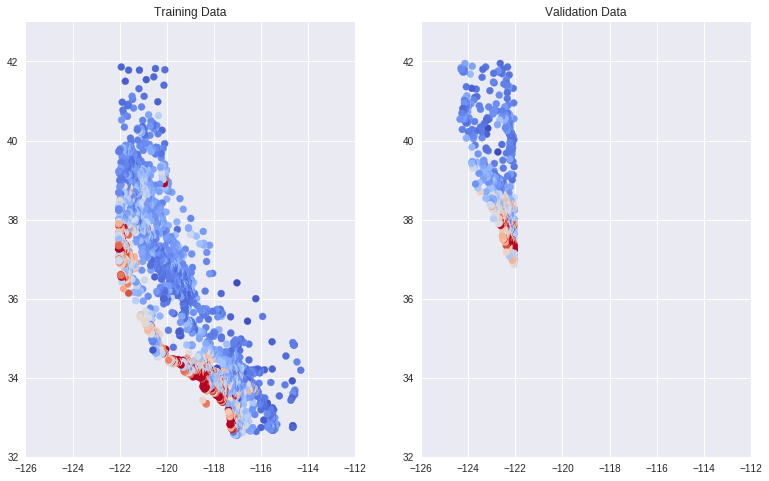

In [282]:
plt.figure(figsize=(13, 8))

ax = plt.subplot(1, 2, 1)
ax.set_title("Training Data")
ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(training_examples["longitude"],
            training_examples["latitude"],
            cmap="coolwarm",
            c=training_examples["median_house_value"] / training_examples["median_house_value"].max())

ax = plt.subplot(1, 2, 2)
ax.set_title("Validation Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(validation_examples["longitude"],
            validation_examples["latitude"],
            cmap="coolwarm",
            c=validation_examples["median_house_value"] / validation_examples["median_house_value"].max())

_ = plt.plot()

## Task 1: Train a Model (1 point)

Pick the single feature that you think would lead to the best model to prdict the `median_house_value`. Adjust the learning_rate and steps to train a good model.  HINT: you should be able to get the RMSE down to around 80.  Using `households` is not a good choice! Look at what other features are available.

Training model...
  Training loss after period 00 : 132.082
  Training loss after period 01 : 81.639
  Training loss after period 02 : 82.647
  Training loss after period 03 : 81.363
  Training loss after period 04 : 82.193
  Training loss after period 05 : 81.191
  Training loss after period 06 : 81.938
  Training loss after period 07 : 81.078
  Training loss after period 08 : 81.781
  Training loss after period 09 : 81.003
Final Training Loss (RMSE): 81.003
Final Validation Loss (RMSE): 96.858


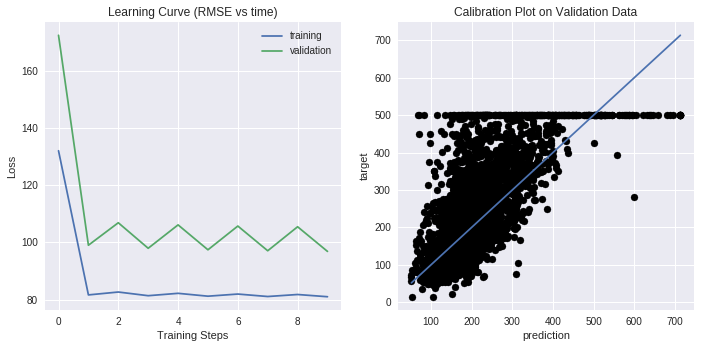

In [283]:
NUMERICAL_FEATURES = ["median_income"]
LABEL = "median_house_value"


LEARNING_RATE = 1
STEPS = 50

linear_regressor = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressor = train_model(linear_regressor, steps=STEPS)

### Load the Provided Test Data

This data set (as with many) comes with a provided test data set that is representative and is used to evaluate the final performance. For this data set, the provided test data is located [here](https://storage.googleapis.com/ml_universities/california_housing_test.csv).

The purpose of having validation data is to notice overfitting and other problems. Remember our key goal is to train a model that will make good predictions on **new unseen data**. Remember that the test data should only be used at the end to see how your final model is performing.  It should not be used in helping select which features to use or to select hyperparameter values.

In [284]:
california_housing_test_data = pd.read_csv(
    "https://storage.googleapis.com/ml_universities/california_housing_test.csv",
    sep=",")

test_examples = prepare_features(california_housing_test_data)
test_examples.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00
mean,-119.59,35.64,28.85,2599.58,529.95,1402.80,489.91,3.81,205.85
std,1.99,2.13,12.56,2155.59,415.65,1030.54,365.42,1.85,113.12
min,-124.18,32.56,1.00,6.00,2.00,5.00,2.00,0.50,22.50
25%,-121.81,33.93,18.00,1401.00,291.00,780.00,273.00,2.54,121.20
50%,-118.48,34.27,29.00,2106.00,437.00,1155.00,409.50,3.49,177.65
75%,-118.02,37.69,37.00,3129.00,636.00,1742.75,597.25,4.66,263.97
max,-114.49,41.92,52.00,30450.00,5419.00,11935.00,4930.00,15.00,500.00


## Task 2: Measure the Test Error (1/2 point)

Modify the codebox below to measure the test error. Look at the training error, validation error, and test error for the model you trained in Task 1.  You should only do this after you have picked your hyperparameters.

In [285]:
# put your code here
Test_loss = compute_loss(linear_regressor, eval_input_fn,
                                   test_examples[LABEL])
print(Test_loss)

148.962917635


## Task 3: Recognize the Problem in the Splitting of the Data (1 point)
There's something that we forgot to do above and it is going to cause a problem.  You need to figure out what that is and fix it before you can move on.  Below is some guidance to help you recognize there is a problem and from there you should be able to think through the issue and figure out the cause and what you can do to correct it.

We should see something that resembles a map of California, with red showing up in expensive areas like the San Francisco and Los Angeles. The training set sort of does, but the validation data does not.  Answer the following questions directly in the comment area of the codebox below.

In [243]:
"""
A) Do you see any other differences in the distributions of features or targets
   between the training and validation data?
   
   Yes the difference is that the last 300 records of the 1700 that are used for
   the validation set are all the ones that contain records of northern california
   The data is not randomly distributed, its ordered by location. 
  
B) Why is this happening?
  Its happening because we take the last 300 records of our dataset for our 
  validation set
  
C) How is this problem reflected when you look at the relationship between the
   training error, validation error and test error?
   
   Because our training and validation set arent mixed well with a method such 
   as the K folds method, we end up with a model that isnt very accurate.
"""

'\nA) Do you see any other differences in the distributions of features or targets\n   between the training and validation data?\n   \n   Yes the difference is that the last 300 records of the 1700 that are used for\n   the validation set are all the ones that contain records of northern california\n   The data is not randomly distributed, its ordered by location. \n  \nB) Why is this happening?\n  Its happening because we take the last 300 records of our dataset for our \n  validation set\n  \nC) How is this problem reflected when you look at the relationship between the\n   training error, validation error and test error?\n   \n   Because our training and validation set arent mixed well with a method such \n   as the K folds method, we end up with a model that isnt very accurate.\n'

## Task 4: Fix the Problem (1 point)

Make the changes here to how the training and validation examples are created and call prepare features again. (1 point)


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold 


In [0]:
## Add what you need to this code block to fix the issue you have seen ##


## Regenerate the training and validation examples -- put your changes here

kf = KFold(n_splits = 10, shuffle=True, random_state =None)

df = california_housing_dataframe

result = next(kf.split(df), None)
train = df.iloc[result[0]]
val = df.iloc[result[1]]

training_examples = prepare_features(train) 
validation_examples = prepare_features(val)



#training_examples = prepare_features(california_housing_dataframe.head(14000))
#validation_examples = prepare_features(california_housing_dataframe.tail(3000))


####Here we again view the map view of the data to confirm if the issue has been resolved.  Does this look different than above?  If not, you still have not fixed the issue.  It should be very clear once you have.

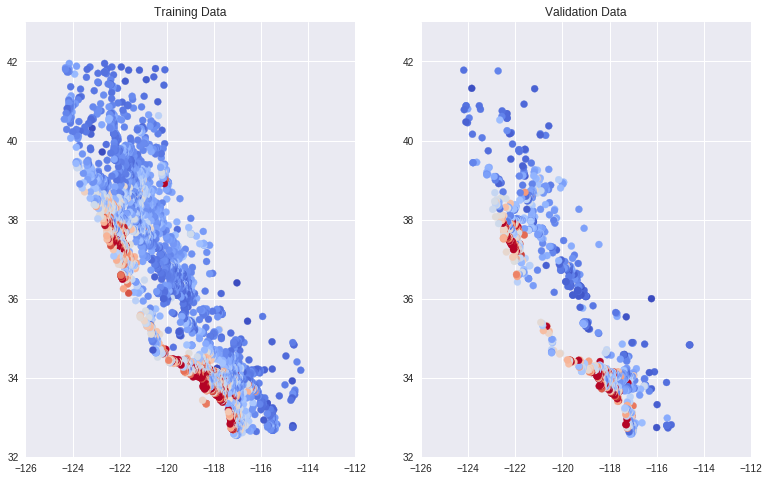

In [291]:
plt.figure(figsize=(13, 8))

ax = plt.subplot(1, 2, 1)
ax.set_title("Training Data")
ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(training_examples["longitude"],
            training_examples["latitude"],
            cmap="coolwarm",
            c=training_examples["median_house_value"] / training_examples["median_house_value"].max())

ax = plt.subplot(1, 2, 2)
ax.set_title("Validation Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(validation_examples["longitude"],
            validation_examples["latitude"],
            cmap="coolwarm",
            c=validation_examples["median_house_value"] / validation_examples["median_house_value"].max())

_ = plt.plot()


## Task 5: Re-train a Model (1 point) 

You may need to adjust your hyperparameter but use the same feature. Again, only use the training and validation data to do this portion.

Training model...
  Training loss after period 00 : 140.263
  Training loss after period 01 : 84.987
  Training loss after period 02 : 85.566
  Training loss after period 03 : 84.912
  Training loss after period 04 : 85.238
  Training loss after period 05 : 84.719
  Training loss after period 06 : 85.026
  Training loss after period 07 : 84.586
  Training loss after period 08 : 84.885
  Training loss after period 09 : 84.496
Final Training Loss (RMSE): 84.496
Final Validation Loss (RMSE): 84.228


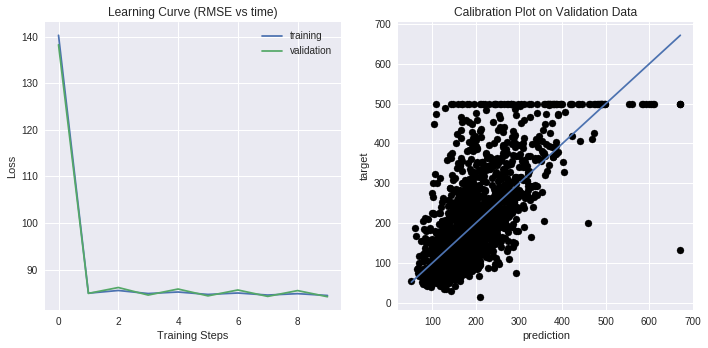

In [300]:
NUMERICAL_FEATURES = ["median_income"]
LABEL = "median_house_value"

LEARNING_RATE = 1
STEPS = 50

linear_regressor = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressor = train_model(linear_regressor, steps=STEPS)

## Task 6: Compute the Test Error for Your New Model (1/2 point)

Compute the test error and then answer the question below.

In [0]:
# Fill this in
test_examples = prepare_features(california_housing_test_data)


In [0]:
Test_loss = compute_loss(linear_regressor, eval_input_fn,
                                   test_examples[LABEL])
print(Test_loss)

In [197]:
"""
How do the training error, validation error and test error now compare to each
other?

ANSWER:
They Are now alot closser to the the test losses. 
"""

'\nHow do the training error, validation error and test error now compare to each\nother?\n\nANSWER:\n'